<a href="https://colab.research.google.com/github/YardenGoraly/Mujoco_fun/blob/main/MuJoCo_fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco as mj
  mj.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


In [4]:
%pip install robot_descriptions
%pip install dm_control

from robot_descriptions import panda_mj_description


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


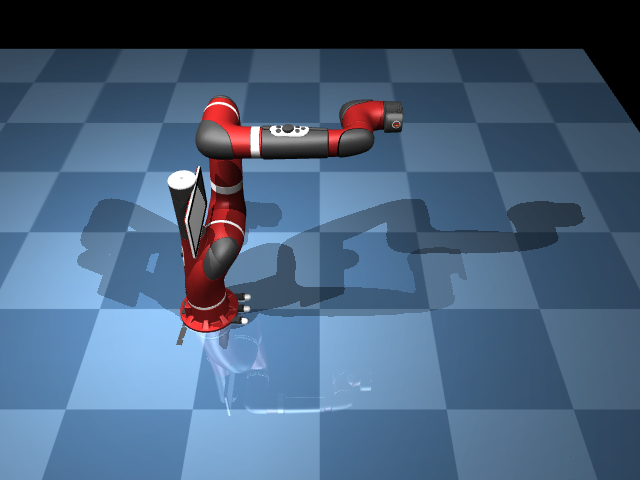

In [52]:
from robot_descriptions.loaders.mujoco import load_robot_description
from dm_control import mjcf
import PIL.Image

ball_xml = """
<mujoco model="ball">
    <worldbody>
        <body name="ball" pos="0.2 0.0 0.1">
            <geom type="sphere" size="0.05" rgba="1 0 0 1"/>
        </body>
    </worldbody>
</mujoco>
"""

hand_path = "mujoco_managerie/wonik_allegro/right_hand.xml"
sawyer_path = "mujoco_managerie/rethink_robotics_sawyer/sawyer.xml"

hand_model = mjcf.from_path(hand_path)
sawyer_model = mjcf.from_path(sawyer_path)
ball_model = mjcf.from_xml_string(ball_xml)

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])

# arena.attach(hand_model)
# arena.attach(ball_model)
sawyer_model.attach(hand_model)
arena.attach(sawyer_model)


# Load model.
physics = mjcf.Physics.from_mjcf_model(arena)

initial_qpos = [0, -1.5, 0, 1.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
physics.data.qpos[:] = initial_qpos
physics.forward()

# renderer = mj.Renderer(arena, height=480, width=640)
PIL.Image.fromarray(physics.render(height=480, width=640))

In [51]:
combined_mjcf_string = sawyer_model.to_xml_string()
with open("combined_model.xml", "w") as f:
    f.write(combined_mjcf_string)

In [53]:
print(physics.data.qpos)

[ 0.  -1.5  0.   1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0. ]


In [11]:
import mujoco_managerie
print(mujoco_managerie.__file__)

None
